In [95]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from IPython import display



In [186]:
(train_images, train_labels), (valid_images, valid_labels) = tf.keras.datasets.cifar10.load_data()


In [187]:
train_labels = np.squeeze(train_labels)
valid_labels = np.squeeze(valid_labels)

train_images = train_images[train_labels == 1]
train_images = train_images[:1000]
valid_images = valid_images[valid_labels == 1]


In [194]:
EPOCHS = 150
ENCODING_DIMS = 256


def convert_to_vae_ds(image, label):
    image = tf.cast(image, tf.float32)
    image = image / tf.reduce_max(image)
    return image, image

train_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(train_images), tf.data.Dataset.from_tensor_slices(np.squeeze(train_labels)))).shuffle(10000).map(convert_to_vae_ds).batch(16)
valid_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(valid_images), tf.data.Dataset.from_tensor_slices(np.squeeze(valid_labels)))).shuffle(10000).map(convert_to_vae_ds).batch(16)
sample = next(iter(train_ds))
sample[0].shape

TensorShape([16, 32, 32, 3])

In [195]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        eps = tf.random.normal(tf.shape(log_var))
        return eps * tf.exp(log_var / 2.) + mean

class VAE_Autoencoder(tf.keras.models.Model):
    def __init__(self, latent_dim):
        super(VAE_Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.enc_inputs = tf.keras.layers.Input(shape=(32, 32, 3))
        self.enc_layer1 = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, padding="same", activation="relu")(self.enc_inputs)
        self.enc_layer2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(self.enc_layer1)
        self.enc_layer3 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(self.enc_layer2)
        self.enc_layer4 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same", activation="relu")(self.enc_layer3)
        self.enc_flatten = tf.keras.layers.Flatten()(self.enc_layer4)
        self.coding_mean = tf.keras.layers.Dense(self.latent_dim, name="mean")(self.enc_flatten)
        self.coding_log_var = tf.keras.layers.Dense(self.latent_dim, name="log_var")(self.enc_flatten)
        self.coding = Sampling(name="encoding")([self.coding_mean, self.coding_log_var])
#         self.coding = tf.keras.layers.Activation("sigmoid")(self.coding)
        self.encoder = tf.keras.models.Model(inputs=[self.enc_inputs], outputs=[self.coding, self.coding_mean, self.coding_log_var])

        self.dec_inputs = tf.keras.layers.Input(shape=(self.latent_dim))
        self.dec_dense = tf.keras.layers.Dense(1024)(self.dec_inputs)
        self.dec_reshape = tf.keras.layers.Reshape(target_shape=(2, 2, 256))(self.dec_dense)
        self.dec_conv1 = tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(self.dec_reshape)
        self.dec_conv2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(self.dec_conv1)
        self.dec_conv3 = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="relu")(self.dec_conv2)
        self.dec_conv4 = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid")(self.dec_conv3)
        self.decoder = tf.keras.models.Model(inputs=[self.dec_inputs], outputs=[self.dec_conv4])

    def call(self, inputs):
        coding, coding_mean, coding_log_var = self.encoder(inputs)
        result = self.decoder(coding)
        
        latent_loss = -0.5 * tf.reduce_sum(1 + coding_log_var - tf.exp(coding_log_var) - tf.square(coding_mean), axis=-1)
        latent_loss_multiplier = tf.shape(inputs)[1] * tf.shape(inputs)[2]
        latent_loss_multiplier = 1000
        latent_loss_scaled = tf.reduce_mean(latent_loss) / tf.cast(latent_loss_multiplier, tf.float32)
        self.add_loss(latent_loss_scaled)
        
        self.add_metric(latent_loss, name="KL_div", aggregation="sum")
        self.add_metric(latent_loss_scaled, name="KL_div_scaled", aggregation="sum")
        self.add_metric(tf.cast(latent_loss_multiplier, tf.float32), name="img_size", aggregation="sum")
        return result
        
model = VAE_Autoencoder(ENCODING_DIMS)

model.compile(loss="mse", optimizer="adam", metrics=["mse", "accuracy"])

In [196]:
#tf.keras.utils.plot_model(model.encoder, show_shapes=True)

In [197]:
#tf.keras.utils.plot_model(model.decoder, show_shapes=True)

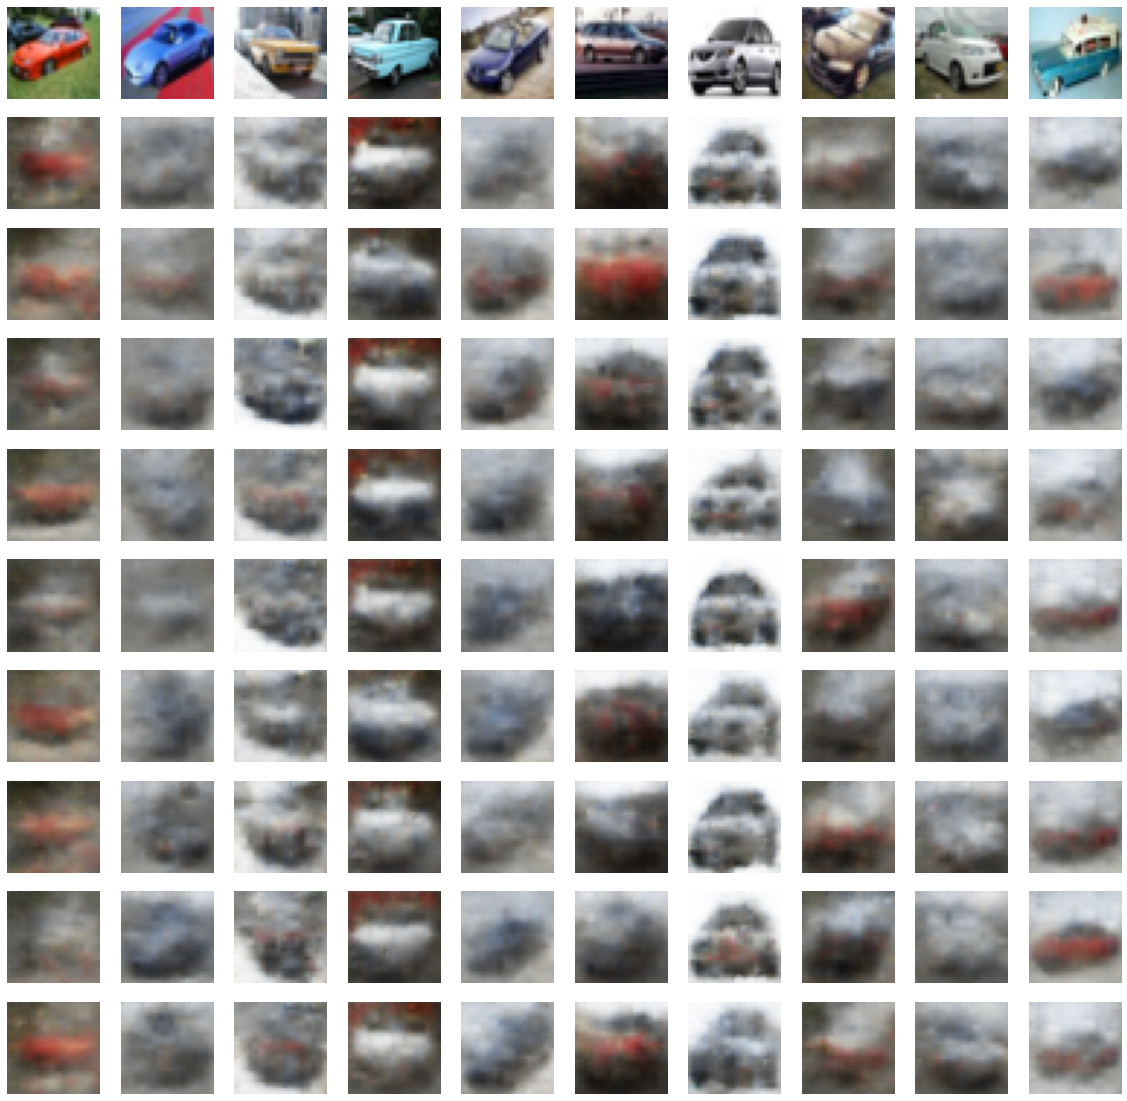

In [215]:
def plot_valid_images():
#     display.clear_output(wait=False)
    plt.figure(figsize=(20, 4))
    for sample in valid_ds.take(1):
        prediction_coding, _, _ = model.encoder(sample[0])
        prediction = model.decoder(prediction_coding)
        
        for idx, items in enumerate(sample[0]):
            if(idx < 10):
                plt.subplot(2, 10, idx + 1)
                plt.axis(False)
                plt.imshow(items)
                plt.subplot(2, 10, idx + 1 + 10)
                plt.axis(False)
                plt.imshow(prediction[idx])

def sample_from_GN():
    plt.figure(figsize=(20, 20))

    for idx0 in range(10):
        images = next(iter(valid_ds))[0]
        image = tf.expand_dims(images[0], axis=0)
        coding, mean, log_var = model.encoder(image)

        plt.subplot(10, 10, 1 + idx0)
        plt.axis(False)
        plt.imshow(image[0])

        for idx1 in range(9):
            coding = Sampling()([mean, log_var])
            generated_image = model.decoder(coding)
            plt.subplot(10, 10, idx0 + 11 + 10 * idx1)
            plt.axis(False)
            plt.imshow(generated_image[0])

# sample_from_GN()
# plot_valid_images()

Epoch 1/150
63/63 [==============================] - 2s 30ms/step - loss: 0.0414 - mse: 0.0325 - accuracy: 0.4736 - KL_div: 8.9333 - KL_div_scaled: 0.0089 - img_size: 1000.0000 - val_loss: 0.0439 - val_mse: 0.0355 - val_accuracy: 0.4202 - val_KL_div: 8.3670 - val_KL_div_scaled: 0.0084 - val_img_size: 1000.0000
Epoch 2/150
63/63 [==============================] - 2s 37ms/step - loss: 0.0417 - mse: 0.0328 - accuracy: 0.4677 - KL_div: 8.9180 - KL_div_scaled: 0.0089 - img_size: 1000.0000 - val_loss: 0.0440 - val_mse: 0.0355 - val_accuracy: 0.4556 - val_KL_div: 8.4484 - val_KL_div_scaled: 0.0085 - val_img_size: 1000.0000
Epoch 3/150
63/63 [==============================] - 2s 37ms/step - loss: 0.0416 - mse: 0.0326 - accuracy: 0.4676 - KL_div: 8.9930 - KL_div_scaled: 0.0090 - img_size: 1000.0000 - val_loss: 0.0441 - val_mse: 0.0351 - val_accuracy: 0.4637 - val_KL_div: 9.0271 - val_KL_div_scaled: 0.0090 - val_img_size: 1000.0000
Epoch 4/150
63/63 [==============================] - 2s 37ms/ste

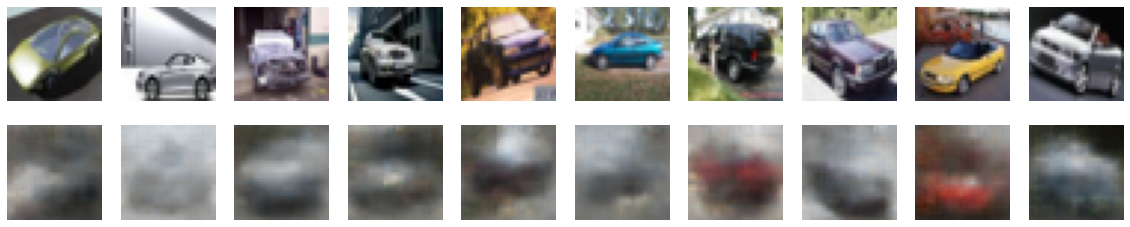

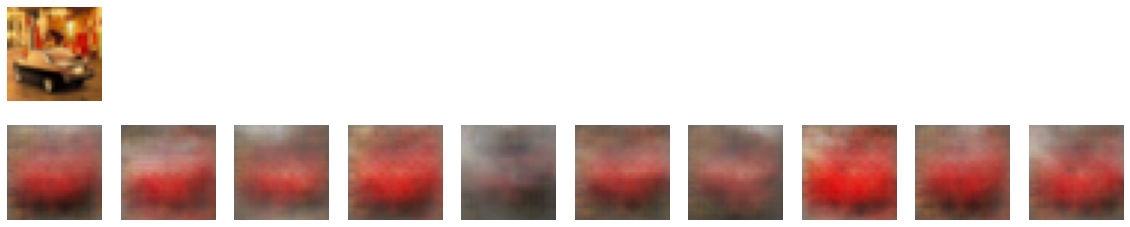

63/63 [==============================] - 4s 59ms/step - loss: 0.0411 - mse: 0.0320 - accuracy: 0.4719 - KL_div: 9.1042 - KL_div_scaled: 0.0091 - img_size: 1000.0000 - val_loss: 0.0438 - val_mse: 0.0353 - val_accuracy: 0.4431 - val_KL_div: 8.4357 - val_KL_div_scaled: 0.0085 - val_img_size: 1000.0000
Epoch 11/150
63/63 [==============================] - 2s 35ms/step - loss: 0.0410 - mse: 0.0320 - accuracy: 0.4739 - KL_div: 8.9664 - KL_div_scaled: 0.0090 - img_size: 1000.0000 - val_loss: 0.0447 - val_mse: 0.0353 - val_accuracy: 0.4288 - val_KL_div: 9.3990 - val_KL_div_scaled: 0.0094 - val_img_size: 1000.0000
Epoch 12/150
63/63 [==============================] - 2s 35ms/step - loss: 0.0411 - mse: 0.0319 - accuracy: 0.4667 - KL_div: 9.1707 - KL_div_scaled: 0.0092 - img_size: 1000.0000 - val_loss: 0.0441 - val_mse: 0.0355 - val_accuracy: 0.4555 - val_KL_div: 8.6519 - val_KL_div_scaled: 0.0086 - val_img_size: 1000.0000
Epoch 13/150
63/63 [==============================] - 2s 36ms/step - loss:

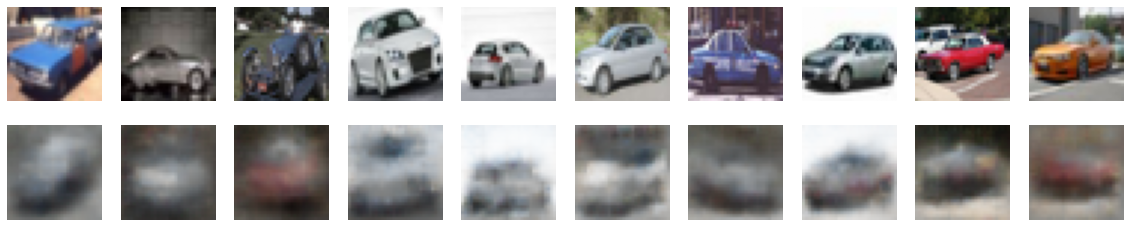

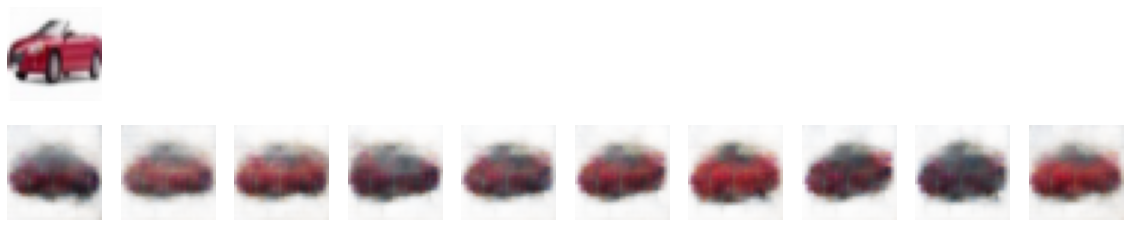

63/63 [==============================] - 4s 61ms/step - loss: 0.0411 - mse: 0.0319 - accuracy: 0.4704 - KL_div: 9.2378 - KL_div_scaled: 0.0092 - img_size: 1000.0000 - val_loss: 0.0437 - val_mse: 0.0349 - val_accuracy: 0.4581 - val_KL_div: 8.8422 - val_KL_div_scaled: 0.0088 - val_img_size: 1000.0000
Epoch 21/150
63/63 [==============================] - 2s 37ms/step - loss: 0.0406 - mse: 0.0314 - accuracy: 0.4790 - KL_div: 9.1810 - KL_div_scaled: 0.0092 - img_size: 1000.0000 - val_loss: 0.0439 - val_mse: 0.0352 - val_accuracy: 0.4615 - val_KL_div: 8.6898 - val_KL_div_scaled: 0.0087 - val_img_size: 1000.0000
Epoch 22/150
63/63 [==============================] - 2s 40ms/step - loss: 0.0408 - mse: 0.0316 - accuracy: 0.4811 - KL_div: 9.1867 - KL_div_scaled: 0.0092 - img_size: 1000.0000 - val_loss: 0.0439 - val_mse: 0.0351 - val_accuracy: 0.4417 - val_KL_div: 8.7635 - val_KL_div_scaled: 0.0088 - val_img_size: 1000.0000
Epoch 23/150
63/63 [==============================] - 3s 41ms/step - loss:

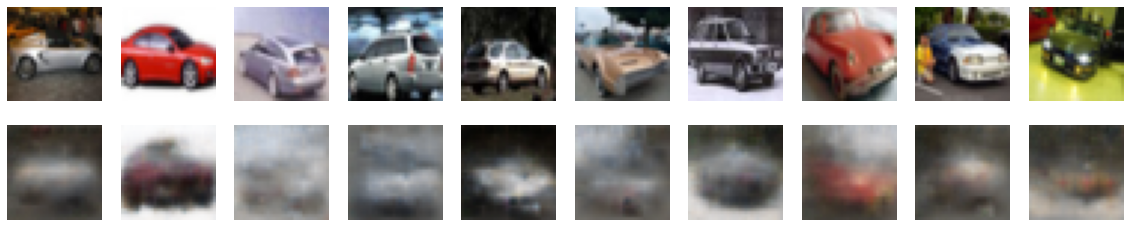

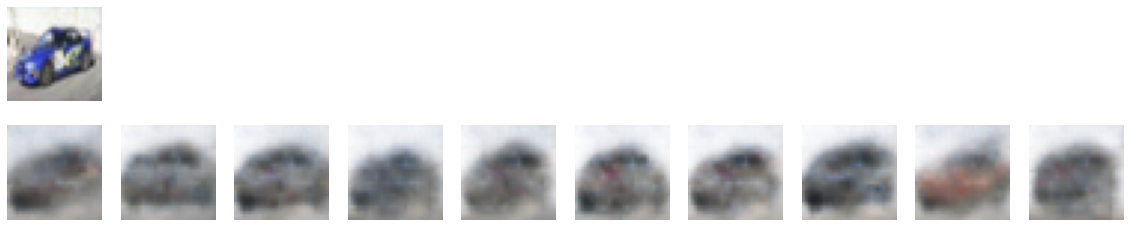

63/63 [==============================] - 5s 82ms/step - loss: 0.0408 - mse: 0.0313 - accuracy: 0.4810 - KL_div: 9.4362 - KL_div_scaled: 0.0094 - img_size: 1000.0000 - val_loss: 0.0438 - val_mse: 0.0352 - val_accuracy: 0.4584 - val_KL_div: 8.6207 - val_KL_div_scaled: 0.0086 - val_img_size: 1000.0000
Epoch 31/150
63/63 [==============================] - 3s 45ms/step - loss: 0.0408 - mse: 0.0314 - accuracy: 0.4777 - KL_div: 9.4363 - KL_div_scaled: 0.0094 - img_size: 1000.0000 - val_loss: 0.0440 - val_mse: 0.0345 - val_accuracy: 0.4266 - val_KL_div: 9.4308 - val_KL_div_scaled: 0.0094 - val_img_size: 1000.0000
Epoch 32/150
63/63 [==============================] - 2s 37ms/step - loss: 0.0407 - mse: 0.0313 - accuracy: 0.4723 - KL_div: 9.4598 - KL_div_scaled: 0.0095 - img_size: 1000.0000 - val_loss: 0.0436 - val_mse: 0.0348 - val_accuracy: 0.4747 - val_KL_div: 8.7596 - val_KL_div_scaled: 0.0088 - val_img_size: 1000.0000
Epoch 33/150
63/63 [==============================] - 2s 38ms/step - loss:

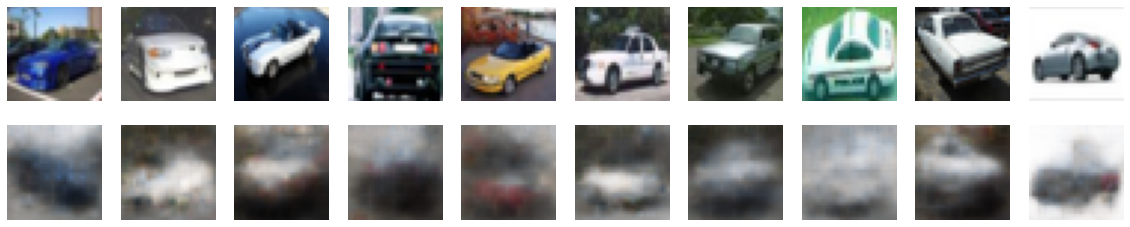

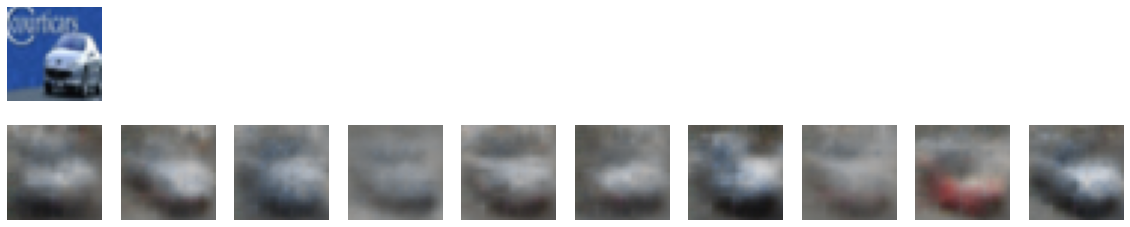

63/63 [==============================] - 4s 67ms/step - loss: 0.0405 - mse: 0.0311 - accuracy: 0.4759 - KL_div: 9.4160 - KL_div_scaled: 0.0094 - img_size: 1000.0000 - val_loss: 0.0439 - val_mse: 0.0346 - val_accuracy: 0.4690 - val_KL_div: 9.2740 - val_KL_div_scaled: 0.0093 - val_img_size: 1000.0000
Epoch 41/150
63/63 [==============================] - 3s 52ms/step - loss: 0.0401 - mse: 0.0308 - accuracy: 0.4802 - KL_div: 9.3216 - KL_div_scaled: 0.0093 - img_size: 1000.0000 - val_loss: 0.0441 - val_mse: 0.0353 - val_accuracy: 0.4144 - val_KL_div: 8.8259 - val_KL_div_scaled: 0.0088 - val_img_size: 1000.0000
Epoch 42/150
63/63 [==============================] - 3s 42ms/step - loss: 0.0404 - mse: 0.0311 - accuracy: 0.4648 - KL_div: 9.3006 - KL_div_scaled: 0.0093 - img_size: 1000.0000 - val_loss: 0.0439 - val_mse: 0.0348 - val_accuracy: 0.4530 - val_KL_div: 9.1562 - val_KL_div_scaled: 0.0092 - val_img_size: 1000.0000
Epoch 43/150
63/63 [==============================] - 2s 39ms/step - loss:

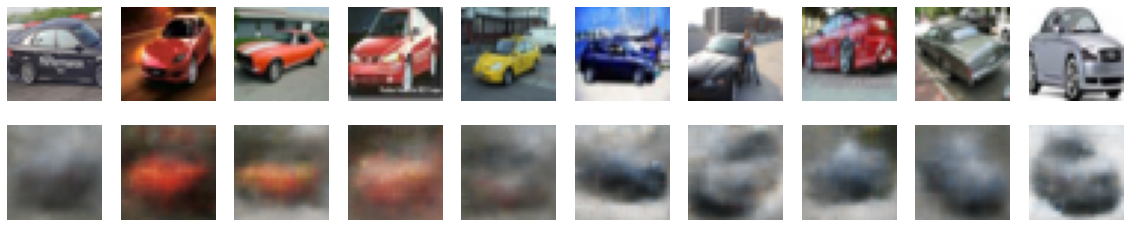

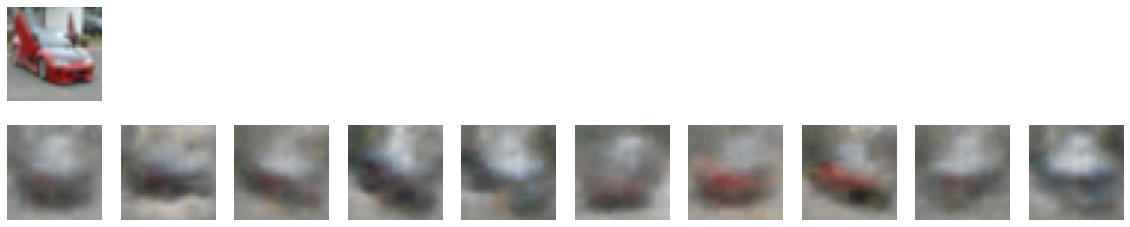

63/63 [==============================] - 4s 63ms/step - loss: 0.0401 - mse: 0.0306 - accuracy: 0.4828 - KL_div: 9.4572 - KL_div_scaled: 0.0095 - img_size: 1000.0000 - val_loss: 0.0439 - val_mse: 0.0346 - val_accuracy: 0.4502 - val_KL_div: 9.2653 - val_KL_div_scaled: 0.0093 - val_img_size: 1000.0000
Epoch 51/150
63/63 [==============================] - 3s 42ms/step - loss: 0.0402 - mse: 0.0307 - accuracy: 0.4769 - KL_div: 9.4989 - KL_div_scaled: 0.0095 - img_size: 1000.0000 - val_loss: 0.0441 - val_mse: 0.0353 - val_accuracy: 0.4656 - val_KL_div: 8.8393 - val_KL_div_scaled: 0.0088 - val_img_size: 1000.0000
Epoch 52/150
63/63 [==============================] - 3s 45ms/step - loss: 0.0403 - mse: 0.0308 - accuracy: 0.4855 - KL_div: 9.5090 - KL_div_scaled: 0.0095 - img_size: 1000.0000 - val_loss: 0.0441 - val_mse: 0.0351 - val_accuracy: 0.4292 - val_KL_div: 8.9261 - val_KL_div_scaled: 0.0089 - val_img_size: 1000.0000
Epoch 53/150
63/63 [==============================] - 3s 43ms/step - loss:

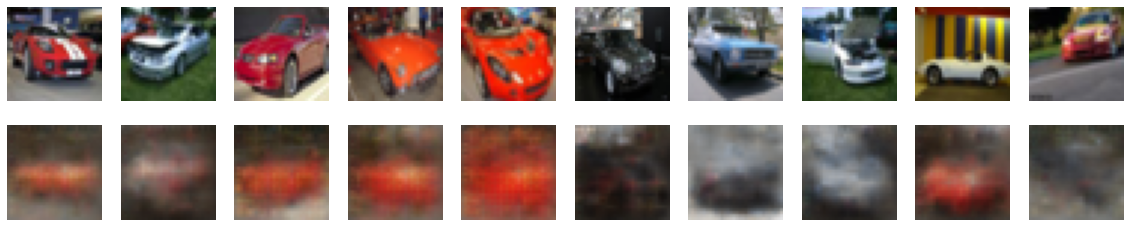

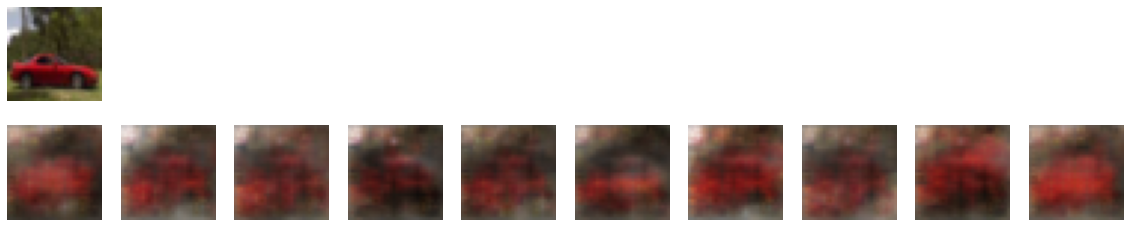

63/63 [==============================] - 4s 59ms/step - loss: 0.0401 - mse: 0.0306 - accuracy: 0.4794 - KL_div: 9.5433 - KL_div_scaled: 0.0095 - img_size: 1000.0000 - val_loss: 0.0442 - val_mse: 0.0348 - val_accuracy: 0.4712 - val_KL_div: 9.4322 - val_KL_div_scaled: 0.0094 - val_img_size: 1000.0000
Epoch 61/150
63/63 [==============================] - 3s 43ms/step - loss: 0.0399 - mse: 0.0305 - accuracy: 0.4874 - KL_div: 9.4410 - KL_div_scaled: 0.0094 - img_size: 1000.0000 - val_loss: 0.0440 - val_mse: 0.0353 - val_accuracy: 0.4616 - val_KL_div: 8.6478 - val_KL_div_scaled: 0.0086 - val_img_size: 1000.0000
Epoch 62/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0400 - mse: 0.0304 - accuracy: 0.4876 - KL_div: 9.5360 - KL_div_scaled: 0.0095 - img_size: 1000.0000 - val_loss: 0.0440 - val_mse: 0.0352 - val_accuracy: 0.4659 - val_KL_div: 8.8116 - val_KL_div_scaled: 0.0088 - val_img_size: 1000.0000
Epoch 63/150
63/63 [==============================] - 3s 43ms/step - loss:

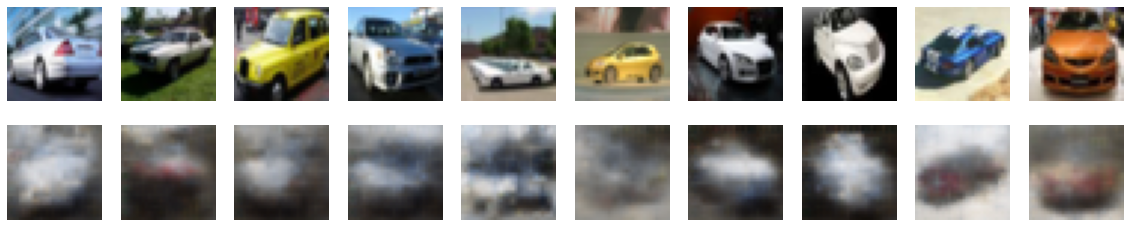

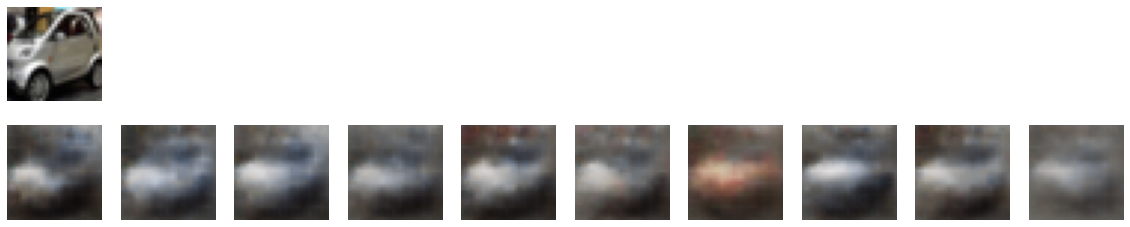

63/63 [==============================] - 4s 59ms/step - loss: 0.0400 - mse: 0.0304 - accuracy: 0.4815 - KL_div: 9.6108 - KL_div_scaled: 0.0096 - img_size: 1000.0000 - val_loss: 0.0441 - val_mse: 0.0348 - val_accuracy: 0.4779 - val_KL_div: 9.3002 - val_KL_div_scaled: 0.0093 - val_img_size: 1000.0000
Epoch 71/150
63/63 [==============================] - 2s 37ms/step - loss: 0.0397 - mse: 0.0301 - accuracy: 0.4868 - KL_div: 9.6485 - KL_div_scaled: 0.0096 - img_size: 1000.0000 - val_loss: 0.0445 - val_mse: 0.0356 - val_accuracy: 0.4803 - val_KL_div: 8.9008 - val_KL_div_scaled: 0.0089 - val_img_size: 1000.0000
Epoch 72/150
63/63 [==============================] - 2s 38ms/step - loss: 0.0396 - mse: 0.0300 - accuracy: 0.4853 - KL_div: 9.5956 - KL_div_scaled: 0.0096 - img_size: 1000.0000 - val_loss: 0.0442 - val_mse: 0.0353 - val_accuracy: 0.4564 - val_KL_div: 8.9337 - val_KL_div_scaled: 0.0089 - val_img_size: 1000.0000
Epoch 73/150
63/63 [==============================] - 3s 43ms/step - loss:

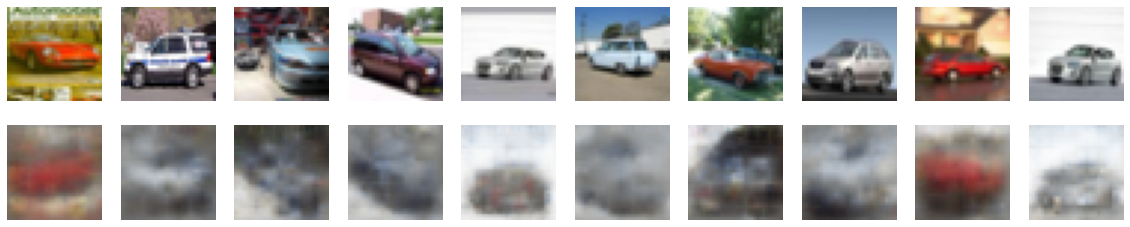

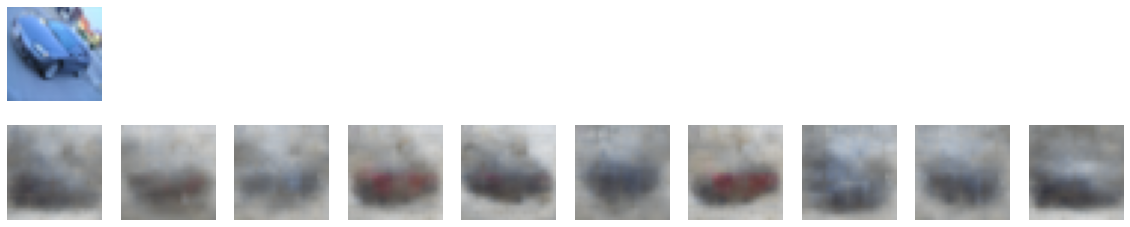

63/63 [==============================] - 4s 62ms/step - loss: 0.0394 - mse: 0.0298 - accuracy: 0.4833 - KL_div: 9.5939 - KL_div_scaled: 0.0096 - img_size: 1000.0000 - val_loss: 0.0442 - val_mse: 0.0353 - val_accuracy: 0.4548 - val_KL_div: 8.9513 - val_KL_div_scaled: 0.0090 - val_img_size: 1000.0000
Epoch 81/150
63/63 [==============================] - 2s 37ms/step - loss: 0.0396 - mse: 0.0301 - accuracy: 0.4846 - KL_div: 9.5534 - KL_div_scaled: 0.0095 - img_size: 1000.0000 - val_loss: 0.0443 - val_mse: 0.0351 - val_accuracy: 0.4318 - val_KL_div: 9.1848 - val_KL_div_scaled: 0.0092 - val_img_size: 1000.0000
Epoch 82/150
63/63 [==============================] - 2s 37ms/step - loss: 0.0393 - mse: 0.0297 - accuracy: 0.4884 - KL_div: 9.6604 - KL_div_scaled: 0.0097 - img_size: 1000.0000 - val_loss: 0.0443 - val_mse: 0.0353 - val_accuracy: 0.4416 - val_KL_div: 8.9738 - val_KL_div_scaled: 0.0090 - val_img_size: 1000.0000
Epoch 83/150
63/63 [==============================] - 2s 37ms/step - loss:

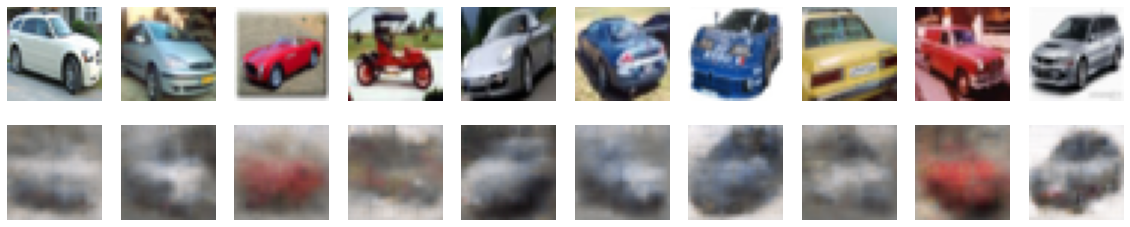

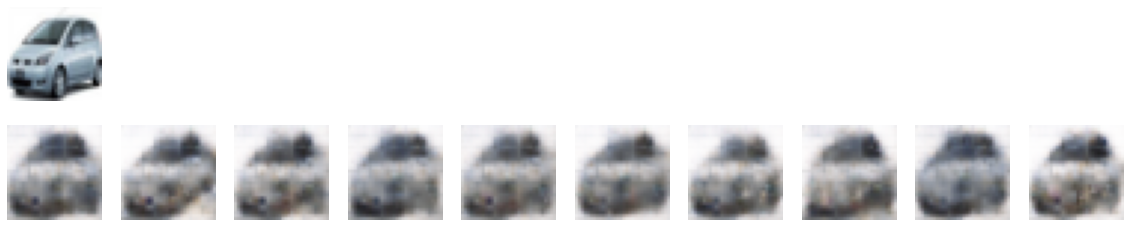

63/63 [==============================] - 4s 71ms/step - loss: 0.0396 - mse: 0.0297 - accuracy: 0.4909 - KL_div: 9.8791 - KL_div_scaled: 0.0099 - img_size: 1000.0000 - val_loss: 0.0445 - val_mse: 0.0354 - val_accuracy: 0.4856 - val_KL_div: 9.0494 - val_KL_div_scaled: 0.0091 - val_img_size: 1000.0000
Epoch 91/150
63/63 [==============================] - 2s 37ms/step - loss: 0.0394 - mse: 0.0297 - accuracy: 0.4894 - KL_div: 9.7333 - KL_div_scaled: 0.0097 - img_size: 1000.0000 - val_loss: 0.0445 - val_mse: 0.0348 - val_accuracy: 0.4648 - val_KL_div: 9.7035 - val_KL_div_scaled: 0.0097 - val_img_size: 1000.0000
Epoch 92/150
63/63 [==============================] - 2s 35ms/step - loss: 0.0393 - mse: 0.0296 - accuracy: 0.4846 - KL_div: 9.7420 - KL_div_scaled: 0.0098 - img_size: 1000.0000 - val_loss: 0.0444 - val_mse: 0.0351 - val_accuracy: 0.4518 - val_KL_div: 9.3085 - val_KL_div_scaled: 0.0093 - val_img_size: 1000.0000
Epoch 93/150
63/63 [==============================] - 2s 39ms/step - loss:

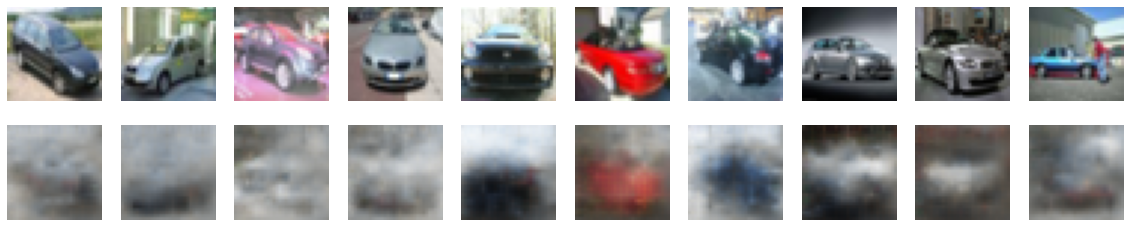

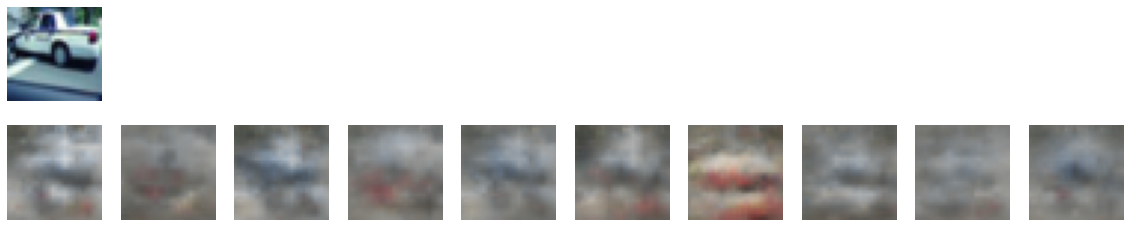

63/63 [==============================] - 5s 72ms/step - loss: 0.0395 - mse: 0.0298 - accuracy: 0.4825 - KL_div: 9.7850 - KL_div_scaled: 0.0098 - img_size: 1000.0000 - val_loss: 0.0450 - val_mse: 0.0350 - val_accuracy: 0.4423 - val_KL_div: 9.9078 - val_KL_div_scaled: 0.0099 - val_img_size: 1000.0000
Epoch 101/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0388 - mse: 0.0292 - accuracy: 0.4865 - KL_div: 9.6213 - KL_div_scaled: 0.0096 - img_size: 1000.0000 - val_loss: 0.0446 - val_mse: 0.0356 - val_accuracy: 0.4175 - val_KL_div: 9.0022 - val_KL_div_scaled: 0.0090 - val_img_size: 1000.0000
Epoch 102/150
63/63 [==============================] - 3s 41ms/step - loss: 0.0393 - mse: 0.0294 - accuracy: 0.4817 - KL_div: 9.9272 - KL_div_scaled: 0.0099 - img_size: 1000.0000 - val_loss: 0.0446 - val_mse: 0.0352 - val_accuracy: 0.4516 - val_KL_div: 9.3998 - val_KL_div_scaled: 0.0094 - val_img_size: 1000.0000
Epoch 103/150
63/63 [==============================] - 2s 38ms/step - lo

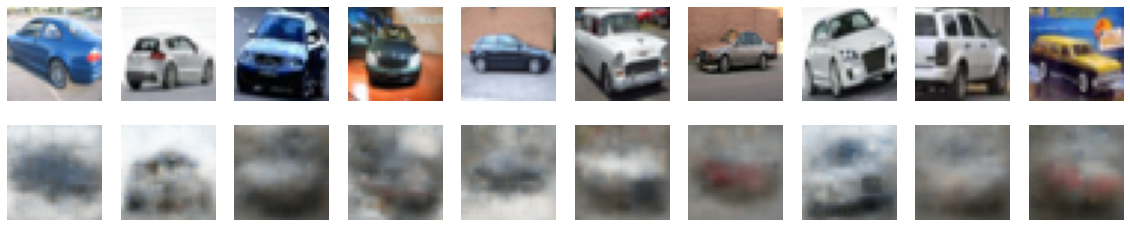

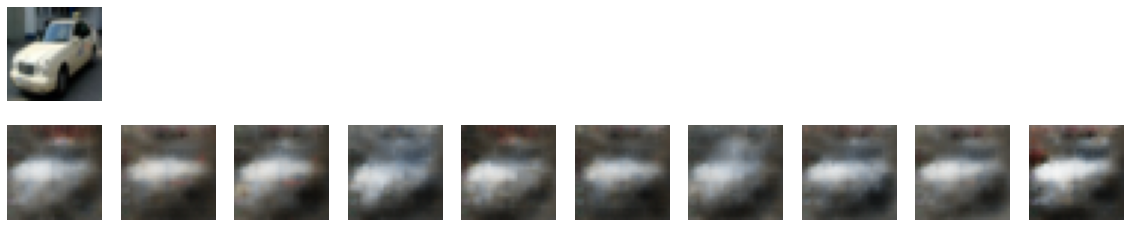

63/63 [==============================] - 4s 62ms/step - loss: 0.0391 - mse: 0.0293 - accuracy: 0.4889 - KL_div: 9.8801 - KL_div_scaled: 0.0099 - img_size: 1000.0000 - val_loss: 0.0446 - val_mse: 0.0355 - val_accuracy: 0.4330 - val_KL_div: 9.0611 - val_KL_div_scaled: 0.0091 - val_img_size: 1000.0000
Epoch 111/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0393 - mse: 0.0294 - accuracy: 0.4750 - KL_div: 9.9111 - KL_div_scaled: 0.0099 - img_size: 1000.0000 - val_loss: 0.0446 - val_mse: 0.0353 - val_accuracy: 0.4679 - val_KL_div: 9.3374 - val_KL_div_scaled: 0.0093 - val_img_size: 1000.0000
Epoch 112/150
63/63 [==============================] - 3s 42ms/step - loss: 0.0392 - mse: 0.0293 - accuracy: 0.4918 - KL_div: 9.8913 - KL_div_scaled: 0.0099 - img_size: 1000.0000 - val_loss: 0.0444 - val_mse: 0.0348 - val_accuracy: 0.4408 - val_KL_div: 9.5493 - val_KL_div_scaled: 0.0095 - val_img_size: 1000.0000
Epoch 113/150
63/63 [==============================] - 3s 43ms/step - lo

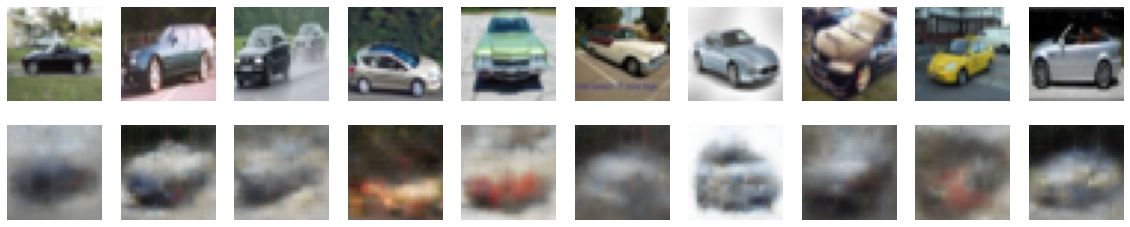

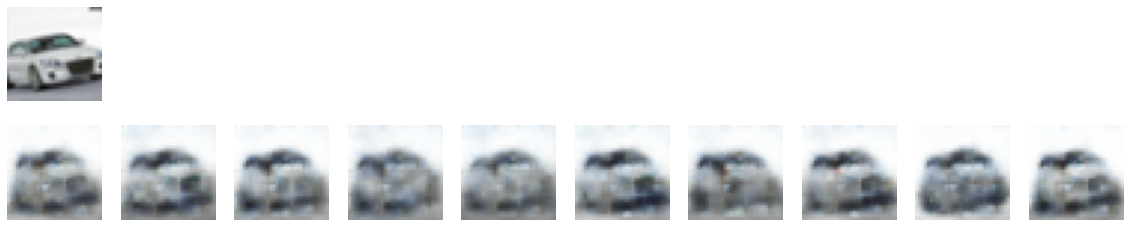

63/63 [==============================] - 4s 61ms/step - loss: 0.0389 - mse: 0.0291 - accuracy: 0.4918 - KL_div: 9.8711 - KL_div_scaled: 0.0099 - img_size: 1000.0000 - val_loss: 0.0450 - val_mse: 0.0353 - val_accuracy: 0.4395 - val_KL_div: 9.6245 - val_KL_div_scaled: 0.0096 - val_img_size: 1000.0000
Epoch 121/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0390 - mse: 0.0290 - accuracy: 0.4891 - KL_div: 9.9455 - KL_div_scaled: 0.0100 - img_size: 1000.0000 - val_loss: 0.0450 - val_mse: 0.0356 - val_accuracy: 0.4057 - val_KL_div: 9.3607 - val_KL_div_scaled: 0.0094 - val_img_size: 1000.0000
Epoch 122/150
63/63 [==============================] - 2s 38ms/step - loss: 0.0390 - mse: 0.0290 - accuracy: 0.4792 - KL_div: 9.9716 - KL_div_scaled: 0.0100 - img_size: 1000.0000 - val_loss: 0.0444 - val_mse: 0.0349 - val_accuracy: 0.4563 - val_KL_div: 9.5286 - val_KL_div_scaled: 0.0095 - val_img_size: 1000.0000
Epoch 123/150
63/63 [==============================] - 3s 41ms/step - lo

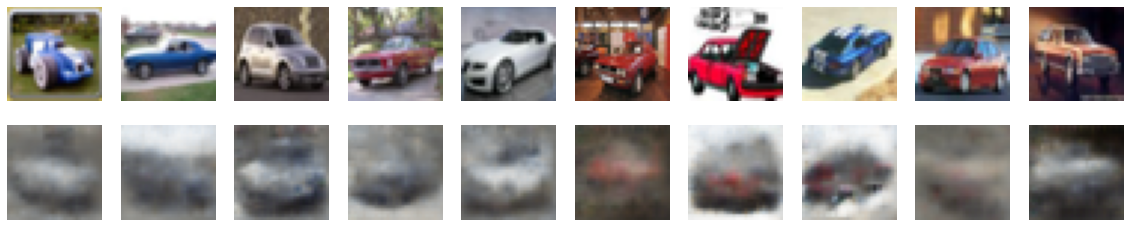

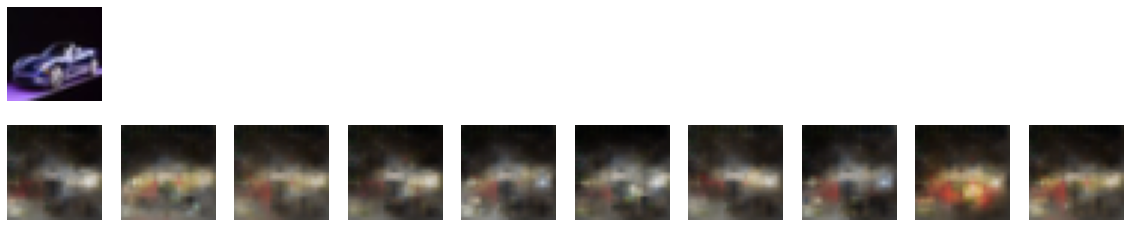

63/63 [==============================] - 4s 68ms/step - loss: 0.0387 - mse: 0.0289 - accuracy: 0.4870 - KL_div: 9.8707 - KL_div_scaled: 0.0099 - img_size: 1000.0000 - val_loss: 0.0451 - val_mse: 0.0355 - val_accuracy: 0.4480 - val_KL_div: 9.6142 - val_KL_div_scaled: 0.0096 - val_img_size: 1000.0000
Epoch 131/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0390 - mse: 0.0290 - accuracy: 0.4830 - KL_div: 9.9769 - KL_div_scaled: 0.0100 - img_size: 1000.0000 - val_loss: 0.0450 - val_mse: 0.0354 - val_accuracy: 0.4644 - val_KL_div: 9.5748 - val_KL_div_scaled: 0.0096 - val_img_size: 1000.0000
Epoch 132/150
63/63 [==============================] - 3s 43ms/step - loss: 0.0388 - mse: 0.0288 - accuracy: 0.4897 - KL_div: 10.0526 - KL_div_scaled: 0.0101 - img_size: 1000.0000 - val_loss: 0.0444 - val_mse: 0.0351 - val_accuracy: 0.4457 - val_KL_div: 9.2887 - val_KL_div_scaled: 0.0093 - val_img_size: 1000.0000
Epoch 133/150
63/63 [==============================] - 3s 40ms/step - l

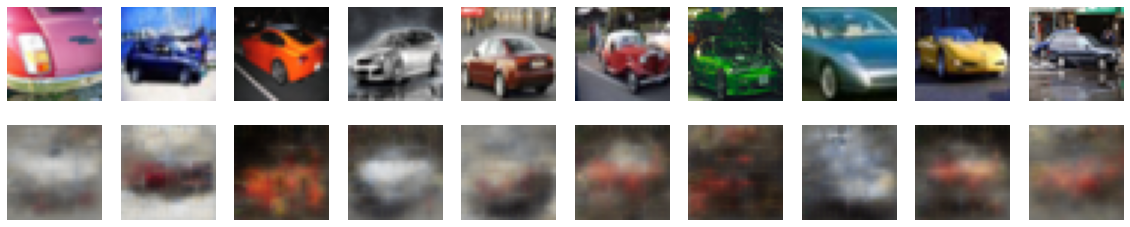

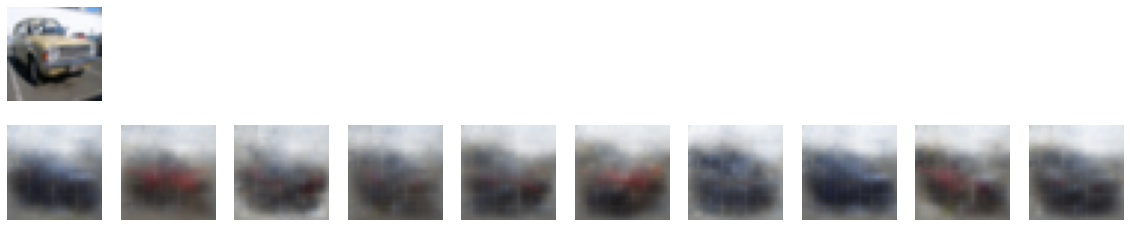

63/63 [==============================] - 4s 70ms/step - loss: 0.0385 - mse: 0.0285 - accuracy: 0.4879 - KL_div: 10.0583 - KL_div_scaled: 0.0101 - img_size: 1000.0000 - val_loss: 0.0444 - val_mse: 0.0353 - val_accuracy: 0.4688 - val_KL_div: 9.1171 - val_KL_div_scaled: 0.0091 - val_img_size: 1000.0000
Epoch 141/150
63/63 [==============================] - 2s 40ms/step - loss: 0.0387 - mse: 0.0287 - accuracy: 0.4936 - KL_div: 10.0106 - KL_div_scaled: 0.0100 - img_size: 1000.0000 - val_loss: 0.0448 - val_mse: 0.0351 - val_accuracy: 0.4353 - val_KL_div: 9.6220 - val_KL_div_scaled: 0.0096 - val_img_size: 1000.0000
Epoch 142/150
63/63 [==============================] - 2s 39ms/step - loss: 0.0385 - mse: 0.0284 - accuracy: 0.4843 - KL_div: 10.0865 - KL_div_scaled: 0.0101 - img_size: 1000.0000 - val_loss: 0.0449 - val_mse: 0.0357 - val_accuracy: 0.4691 - val_KL_div: 9.1534 - val_KL_div_scaled: 0.0092 - val_img_size: 1000.0000
Epoch 143/150
63/63 [==============================] - 2s 39ms/step -

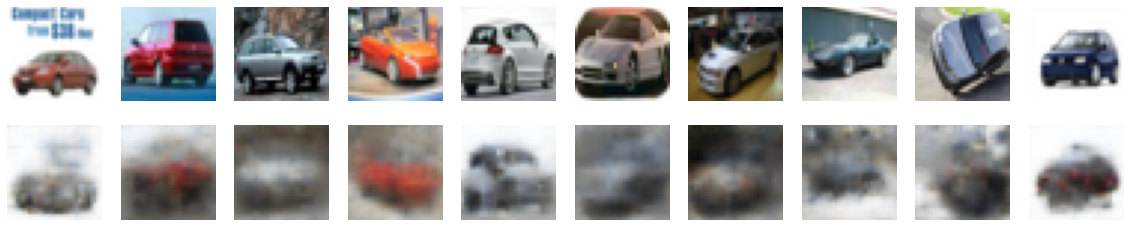

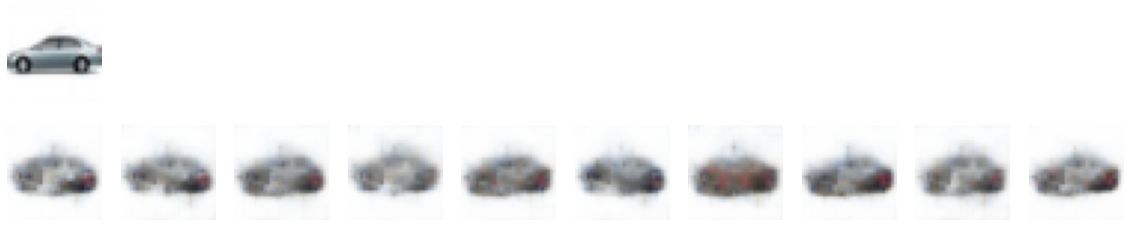

63/63 [==============================] - 4s 67ms/step - loss: 0.0385 - mse: 0.0285 - accuracy: 0.4805 - KL_div: 10.0299 - KL_div_scaled: 0.0100 - img_size: 1000.0000 - val_loss: 0.0453 - val_mse: 0.0358 - val_accuracy: 0.4544 - val_KL_div: 9.5510 - val_KL_div_scaled: 0.0096 - val_img_size: 1000.0000


In [203]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1) % 10 == 0):
            plot_valid_images()
            plt.show()
            sample_from_GN()
            plt.show()
        
#     def on_train_begin(self, epoch, logs=None):
#         plot_valid_images()
#         plt.show()
#         sample_from_GN()
#         plt.show()

history = model.fit(train_ds, epochs = EPOCHS, validation_data = (valid_ds), callbacks=[CustomCallback()])

(0.0, 0.05)

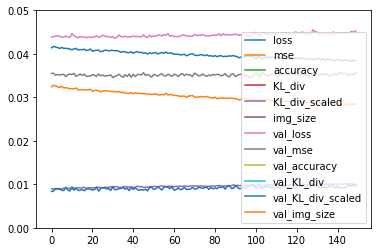

In [204]:
pd.DataFrame(history.history).plot()
plt.ylim(0, 0.05)

(array([  7.,  10.,  27.,  49., 104., 184., 272., 414., 588., 567., 569.,
        487., 325., 233., 137.,  63.,  34.,  21.,   3.,   2.]),
 array([-3.3921123 , -3.0448086 , -2.6975048 , -2.3502011 , -2.0028973 ,
        -1.6555936 , -1.3082899 , -0.9609862 , -0.61368245, -0.26637873,
         0.08092499,  0.4282287 ,  0.7755324 ,  1.1228361 ,  1.4701399 ,
         1.8174436 ,  2.1647472 ,  2.512051  ,  2.8593547 ,  3.2066586 ,
         3.5539622 ], dtype=float32),
 <BarContainer object of 20 artists>)

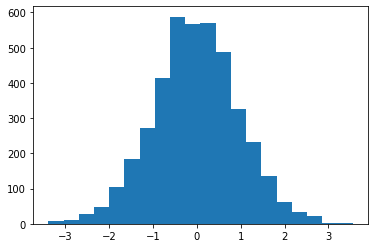

In [205]:
sample_encoding, _, _ = model.encoder(sample[0])

plt.hist(sample_encoding.numpy().ravel(), bins = 20)

(array([ 1.,  2.,  5.,  8., 12., 13., 23., 24., 24., 21., 32., 31., 19.,
        17., 12.,  2.,  2.,  4.,  1.,  3.]),
 array([-0.7028085 , -0.6316053 , -0.5604021 , -0.48919892, -0.41799572,
        -0.34679252, -0.27558932, -0.20438613, -0.13318293, -0.06197973,
         0.00922346,  0.08042666,  0.15162985,  0.22283305,  0.29403624,
         0.36523944,  0.43644264,  0.50764585,  0.578849  ,  0.65005225,
         0.7212554 ], dtype=float32),
 <BarContainer object of 20 artists>)

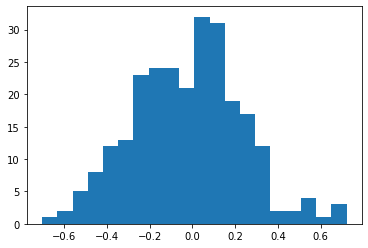

In [206]:
plt.hist(tf.reduce_mean(sample_encoding, axis=0).numpy(), bins=20)

In [209]:
tf.range(0, 50, 32)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 0, 32])>